# Taller (Notebook): Comparación y afinamiento de GA vs ACO en el TSP (TSPLIB)  
## Extensión PLUS: Algoritmo Genético de Chu–Beasley (CBGA)

Este cuaderno guía un mini-proyecto tipo **investigación aplicada** para comparar y afinar:

- 🧬 **Algoritmo Genético clásico (GA)**
- 🐜 **Ant Colony Optimization (ACO)**
- ➕ **Chu–Beasley Genetic Algorithm (CBGA)**

**Regla del taller:** este cuaderno **no incluye código de referencia** (solo estructura, criterios y plantillas).  
Los estudiantes deben implementar los algoritmos y reportar resultados con metodología experimental.

## Requisitos

- Python 3.10+
- Librerías sugeridas: `tsplib95`, `numpy`, `matplotlib`
- Instancias TSPLIB recomendadas: `eil51`, `berlin52`, `att48`, `st70` (o equivalentes)

> Nota: Si tu entorno no tiene TSPLIB a la mano, el docente puede proveer los `.tsp` o una carpeta `data/`.

## Objetivos del taller

1. Implementar GA, ACO y CBGA para TSP usando instancias TSPLIB.
2. Definir una metodología experimental **justa** (mismo presupuesto computacional).
3. Medir y comparar desempeño: **distancia**, **tiempo**, **convergencia**, **estabilidad** (variabilidad).
4. Realizar **tuning** (afinamiento) de hiperparámetros para mejorar resultados.
5. Concluir **cuál es “mejor”** bajo distintos criterios (no existe un único ganador universal).

## ¿Qué significa “mejor”?

En este taller, “mejor” se define con **múltiples criterios**:

- **Calidad:** menor longitud de tour (distancia).
- **Rapidez:** menor tiempo para lograr buena calidad.
- **Estabilidad:** baja variación entre corridas (desviación estándar pequeña).
- **Escalabilidad:** se degrada menos al aumentar el tamaño del problema.

El reporte final debe explicar **qué criterio prioriza** tu conclusión.

---

# 1) Planteamiento del problema (TSP) y TSPLIB

El **TSP** busca un ciclo Hamiltoniano de costo mínimo.

### Tareas
- Elegir 2–3 instancias TSPLIB (al menos una de ~50 nodos y otra más grande).
- Registrar si cada instancia tiene óptimo conocido (cuando esté disponible).

In [ ]:
# Configurar rutas y cargar instancias TSPLIB
# - Define una lista de paths de archivos .tsp (por ejemplo: data/berlin52.tsp).
# - Carga cada instancia, extrae dimensión y (si existe) el óptimo conocido.
# - Define una función para evaluar la longitud de un tour.

# Escribe tu implementación aquí.

import numpy as np
import math
import random
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# CONFIGURAR RUTAS
# =====================================================

TSP_FILES = [
    "berlin52.tsp",
    "st70.tsp"
]

# Óptimos conocidos
OPTIMOS_CONOCIDOS = {
    "berlin52.tsp": 7542,
    "st70.tsp": 675
}

# =====================================================
# CARGA INSTANCIA TSPLIB
# =====================================================

def cargar_tsp(ruta):
    coordenadas = []
    dimension = None
    leyendo = False

    with open(ruta, 'r') as f:
        for linea in f:
            linea = linea.strip()

            if linea.startswith("DIMENSION"):
                dimension = int(linea.split(":")[1])

            if linea == "NODE_COORD_SECTION":
                leyendo = True
                continue

            if linea == "EOF":
                break

            if leyendo:
                partes = linea.split()
                if len(partes) >= 3:
                    _, x, y = partes[:3]
                    coordenadas.append((float(x), float(y)))

    coordenadas = np.array(coordenadas)

    if dimension is None:
        dimension = len(coordenadas)

    nombre = os.path.basename(ruta)
    optimo = OPTIMOS_CONOCIDOS.get(nombre, None)

    return {
        "nombre": nombre,
        "dimension": dimension,
        "optimo": optimo,
        "coordenadas": coordenadas
    }

# =====================================================
# MATRIZ DE DISTANCIAS
# =====================================================

def matriz_distancias(coordenadas):
    n = len(coordenadas)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                dist[i][j] = math.sqrt(
                    (coordenadas[i][0] - coordenadas[j][0])**2 +
                    (coordenadas[i][1] - coordenadas[j][1])**2
                )
    return dist

# =====================================================
# EVALUAR TOUR
# =====================================================

def evaluar_tour(tour, distancias):
    total = 0
    n = len(tour)

    for i in range(n - 1):
        total += distancias[tour[i]][tour[i+1]]

    # cerrar ciclo
    total += distancias[tour[-1]][tour[0]]

    return total

# =====================================================
# CARGAR TODAS LAS INSTANCIAS
# =====================================================

instancias = []

for ruta in TSP_FILES:
    instancia = cargar_tsp(ruta)
    instancia["distancias"] = matriz_distancias(instancia["coordenadas"])
    instancias.append(instancia)

    print(f"Instancia: {instancia['nombre']}")
    print(f"Dimensión: {instancia['dimension']}")
    print(f"Óptimo conocido: {instancia['optimo']}")
    print("-" * 40)


Instancia: berlin52.tsp
Dimensión: 52
Óptimo conocido: 7542
----------------------------------------
Instancia: st70.tsp
Dimensión: 70
Óptimo conocido: 675
----------------------------------------


---

# 2) Metodología experimental

## Presupuesto computacional (fair comparison)
Para comparar algoritmos metaheurísticos, evita comparar “a ojo”.  
Elige una de estas estrategias (y úsala para TODOS):

**Opción A: Presupuesto por tiempo**
- Cada algoritmo corre **T segundos** por instancia y semilla.

**Opción B: Presupuesto por evaluaciones**
- Cada algoritmo puede evaluar **N tours** (aprox.) por corrida.

**Opción C: Presupuesto por iteraciones equivalente**
- Mismas iteraciones y poblaciones/hormigas (menos robusto si costos difieren).

✅ Recomendación: **A o B**.

## Repeticiones
- Ejecuta al menos **30 seeds** por algoritmo e instancia.

## Métricas mínimas
- Mejor distancia (best)
- Promedio y desviación estándar
- Tiempo promedio
- Curva de convergencia (best-so-far vs iteración/tiempo)
- GAP (%) si se conoce óptimo:
\[
GAP = \frac{L_{alg}-L_{opt}}{L_{opt}}\times 100
\]

berlin52.tsp | GA | Seed 0 → 10698.22
berlin52.tsp | GA | Seed 1 → 13006.10
berlin52.tsp | ACO | Seed 0 → 8124.97
berlin52.tsp | ACO | Seed 1 → 8134.55
berlin52.tsp | CBGA | Seed 0 → 9800.96
berlin52.tsp | CBGA | Seed 1 → 9721.22
st70.tsp | GA | Seed 0 → 1520.58
st70.tsp | GA | Seed 1 → 1219.32
st70.tsp | ACO | Seed 0 → 767.01
st70.tsp | ACO | Seed 1 → 751.51
st70.tsp | CBGA | Seed 0 → 1352.16
st70.tsp | CBGA | Seed 1 → 1369.44

=========== RESUMEN FINAL ===========
                        mejor_global      promedio          std  \
instancia    algoritmo                                            
berlin52.tsp ACO         8124.970898   8129.762149     6.775852   
             CBGA        9721.223493   9761.092583    56.383408   
             GA         10698.224371  11852.163245  1631.916006   
st70.tsp     ACO          751.510473    759.260338    10.959964   
             CBGA        1352.158210   1360.796740    12.216726   
             GA          1219.319707   1369.948255   213.020

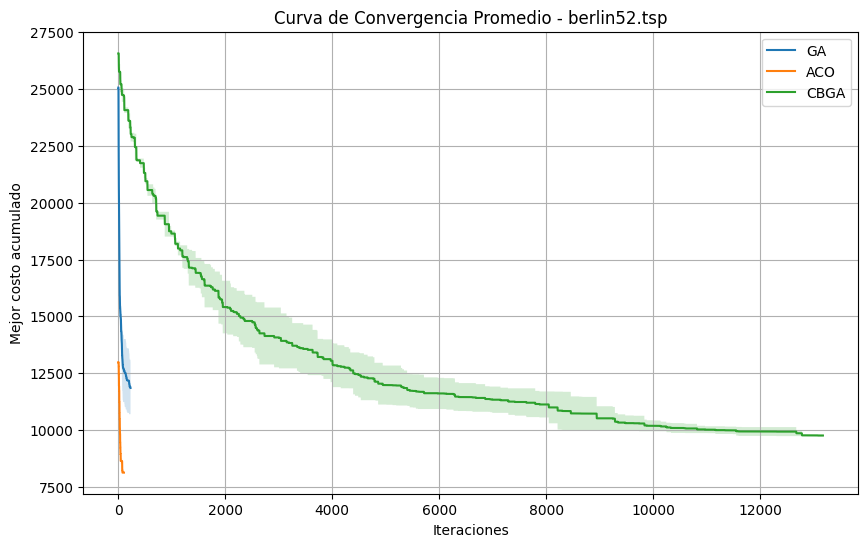

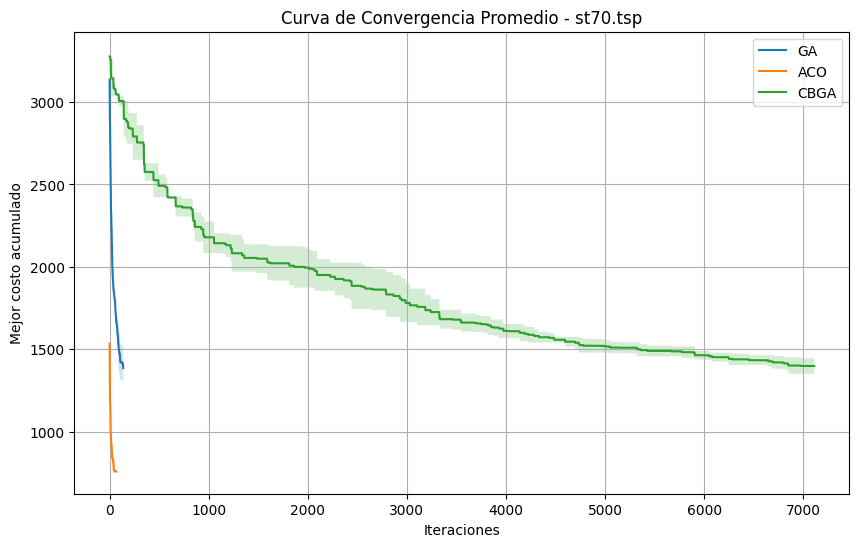

In [ ]:
# Diseñar el runner experimental (multi-seed)
# - Define seeds (por ejemplo 30).
# - Define una función run_experiment(algoritmo, instancia, seed, presupuesto).
# - Guarda resultados en una tabla (CSV/DF): instancia, algoritmo, seed, best, tiempo, historial.

# Escribe tu implementación aquí.


# =====================================================
# CONFIGURACIÓN EXPERIMENTAL
# =====================================================
MAX_TIME = 3
N_SEEDS = 30       # número de corridas independientes
BUDGET = 3          # presupuesto en segundos por ejecución


# =====================================================
# RUNNER EXPERIMENTAL
# =====================================================

def run_experiment(algoritmo, instancia, seed, presupuesto, config=None):

    random.seed(seed)
    np.random.seed(seed)

    global MAX_TIME
    MAX_TIME = presupuesto

    inicio = time.time()

    if algoritmo == "GA":

        if config is None:
            # BASELINE
            _, best, history = genetic_tsp(
                instancia["dimension"],
                instancia["distancias"]
            )
        else:
            # TUNING
            _, best, history = genetic_tsp(
                instancia["dimension"],
                instancia["distancias"],
                pop_size=config["pop_size"],
                mutation_rate=config["mutation_rate"],
                crossover_rate=config["crossover_rate"],
                elite_size=config["elite_size"]
            )
    elif algoritmo == "ACO":
        _, best, history = aco_tsp(instancia["distancias"])

    elif algoritmo == "CBGA":

        if config is None:
            config = {}

        _, best, history = cbga_tsp(
            instancia["dimension"],
            instancia["distancias"],
            pop_size=config.get("pop_size",100),
            mutation_rate=config.get("mutation_rate",0.2),
            diversity_factor=config.get("diversity_factor",0.05),
            replacement_strategy=config.get("replacement_strategy","worst"),
            two_opt_mode=config.get("two_opt","off")
        )

    else:
        raise ValueError("Algoritmo no reconocido")

    tiempo = time.time() - inicio
    optimo = instancia["optimo"]
    gap = ((best - optimo) / optimo) * 100 if optimo else None

    result = {
        "instancia": instancia["nombre"],
        "algoritmo": algoritmo,
        "seed": seed,
        "best": best,
        "tiempo": tiempo,
        "gap_%": gap,
        "history": history
    }

    # Guardar hiperparámetros si existen
    if config:
        for k, v in config.items():
            result[k] = v

    return result

# =====================================================
# EJECUCIÓN MULTI-SEED
# =====================================================

all_results = []

for instancia in instancias:
    for algoritmo in ["GA", "ACO", "CBGA"]:
        for seed in range(N_SEEDS):

            result = run_experiment(algoritmo, instancia, seed, BUDGET)
            all_results.append(result)

            print(f"{instancia['nombre']} | {algoritmo} | Seed {seed} → {result['best']:.2f}")

# =====================================================
# GUARDAR RESULTADOS
# =====================================================

df = pd.DataFrame(all_results)

df.to_csv("resultados_experimento.csv", index=False)

# =====================================================
# ESTADÍSTICAS
# =====================================================

resumen = df.groupby(["instancia","algoritmo"]).agg(
    mejor_global=("best","min"),
    promedio=("best","mean"),
    std=("best","std"),
    tiempo_promedio=("tiempo","mean"),
    gap_promedio=("gap_%","mean")
)

print("\n=========== RESUMEN FINAL ===========")
print(resumen)

# =====================================================
# FUNCIÓN CURVA PROMEDIO
# =====================================================

def curva_promedio(df, instancia, algoritmo):

    subset = df[(df["instancia"] == instancia) &
                (df["algoritmo"] == algoritmo)]

    histories = subset["history"].tolist()

    min_len = min(len(h) for h in histories)
    histories = [h[:min_len] for h in histories]

    promedio = np.mean(histories, axis=0)
    std = np.std(histories, axis=0)

    return promedio, std
# =====================================================
# GRAFICAR CURVAS PROMEDIO (FASE 1)
# =====================================================

def graficar_curva(df, instancia):

    plt.figure(figsize=(10,6))

    for algoritmo in ["GA", "ACO", "CBGA"]:

        promedio, std = curva_promedio(df, instancia, algoritmo)

        x = range(len(promedio))

        plt.plot(x, promedio, label=algoritmo)
        plt.fill_between(
            x,
            promedio - std,
            promedio + std,
            alpha=0.2
        )

    plt.xlabel("Iteraciones")
    plt.ylabel("Mejor costo acumulado")
    plt.title(f"Curva de Convergencia Promedio - {instancia}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Llamar la función para cada instancia
for instancia in df["instancia"].unique():
    graficar_curva(df, instancia)

---

# 3) Implementación conceptual del GA clásico (sin código)

## Componentes mínimos (TSP por permutaciones)
- Representación: permutación de ciudades
- Inicialización: población aleatoria (opcional: heurística NN para algunos individuos)
- Selección: torneo o ruleta
- Cruce: OX (Order Crossover), PMX u otro para permutaciones
- Mutación: swap / inversion / scramble
- Elitismo: conservar los mejores k

## Qué debes decidir (y reportar)
- Tamaño de población P
- Probabilidad de cruce pc
- Probabilidad de mutación pm
- Método de selección
- Elitismo k

In [ ]:
# Implementar GA clásico (plantilla)
# - Define clase/funciones: init_population, selection, crossover, mutation, elitism.
# - Asegura que siempre se produzcan tours válidos (permutaciones sin repetidos).
# - Registra best-so-far por generación/tiempo.

# Escribe tu implementación aquí.

# =====================================================
# GA
# =====================================================

def genetic_tsp(n, distancias, pop_size=100,
                crossover_rate=0.9,
                mutation_rate=0.05,
                elite_size=5):

    start_time = time.time()
    history = []

    # =====================================================
    # INIT POPULATION
    # =====================================================
    def init_population():
        population = []
        for _ in range(pop_size):
            ind = list(range(n))
            random.shuffle(ind)
            population.append(ind)
        return population

    # =====================================================
    # FITNESS
    # =====================================================
    def fitness(ind):
        return evaluar_tour(ind, distancias)

    # =====================================================
    # SELECTION (Torneo)
    # =====================================================
    def selection(population):
        k = 3
        candidates = random.sample(population, k)
        candidates.sort(key=fitness)
        return candidates[0]

    # =====================================================
    # CROSSOVER (Order Crossover)
    # =====================================================
    def crossover(p1, p2):
        a, b = sorted(random.sample(range(n), 2))
        child = [None] * n
        child[a:b] = p1[a:b]

        fill = [c for c in p2 if c not in child]
        idx = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[idx]
                idx += 1

        return child

    # =====================================================
    # MUTATION (swap)
    # =====================================================
    def mutation(ind):
        i, j = random.sample(range(n), 2)
        ind[i], ind[j] = ind[j], ind[i]
        return ind

    # =====================================================
    # ELITISM
    # =====================================================
    def elitism(population):
        population.sort(key=fitness)
        return population[:elite_size]

    # =====================================================
    # MAIN LOOP
    # =====================================================
    population = init_population()

    best = None
    best_cost = float("inf")

    while time.time() - start_time < MAX_TIME:

        new_population = elitism(population)

        while len(new_population) < pop_size:

            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                child = parent1[:]

            if random.random() < mutation_rate:
                child = mutation(child)

            new_population.append(child)

        population = new_population

        # Evaluar mejor
        population.sort(key=fitness)
        current_best = population[0]
        current_cost = fitness(current_best)

        if current_cost < best_cost:
            best_cost = current_cost
            best = current_best

        history.append(best_cost)

    return best, best_cost, history



### Checklist de verificación GA
- [ ] El tour siempre contiene todas las ciudades exactamente una vez.
- [ ] La evaluación del tour es consistente.
- [ ] Se guarda la historia de convergencia.
- [ ] Se puede fijar seed para reproducibilidad.

---

# 4) Implementación conceptual del ACO (sin código)

## Componentes mínimos
- Matriz de feromonas τ(i,j)
- Heurística η(i,j)=1/d(i,j)
- Regla probabilística:
\[
P_{ij} \propto (\tau_{ij})^\alpha (\eta_{ij})^\beta
\]
- Evaporación: τ ← (1−ρ)τ
- Depósito: sumar Q/L en aristas del tour

## Hiperparámetros
- Número de hormigas m
- α (peso feromona)
- β (peso heurística)
- ρ (evaporación)
- Q (intensidad de depósito)
- (opcional) elitist ants / best-ant deposit

## Qué debes decidir (y reportar)
- Cómo eliges el nodo inicial
- Cómo evitas ciclos (conjunto de no visitados)
- Qué esquema de depósito usas

In [ ]:
# Implementar ACO (plantilla)
# - Define: construir_solucion(), actualizar_feromonas(), elegir_siguiente_ciudad().
# - Registra best-so-far por iteración/tiempo.
# - Controla la aleatoriedad con seed.

# Escribe tu implementación aquí.

# =====================================================
# ACO
# =====================================================

def aco_tsp(distancias,
            num_ants=20,
            alpha=1.0,
            beta=2.0,
            rho=0.1,
            Q=100):

    start_time = time.time()
    history = []

    n = len(distancias)

    # Inicializar feromonas con pequeño valor
    tau0 = 1.0
    pheromones = np.full((n, n), tau0)

    best_tour = None
    best_cost = float("inf")

    # =====================================================
    # ELEGIR SIGUIENTE CIUDAD
    # =====================================================
    def elegir_siguiente_ciudad(current, visited):

        probabilities = []
        total = 0.0

        for j in range(n):
            if not visited[j]:
                tau = pheromones[current][j] ** alpha
                eta = (1.0 / (distancias[current][j] + 1e-10)) ** beta
                value = tau * eta
                probabilities.append((j, value))
                total += value

        # Normalización implícita por ruleta
        r = random.random() * total
        cumulative = 0.0

        for city, prob in probabilities:
            cumulative += prob
            if cumulative >= r:
                return city

        return probabilities[-1][0]  # fallback numérico

    # =====================================================
    # CONSTRUIR SOLUCIÓN (una hormiga)
    # =====================================================
    def construir_solucion():

        visited = [False] * n
        tour = []

        current = random.randint(0, n - 1)
        tour.append(current)
        visited[current] = True

        for _ in range(n - 1):
            next_city = elegir_siguiente_ciudad(current, visited)
            tour.append(next_city)
            visited[next_city] = True
            current = next_city

        return tour

    # =====================================================
    # ACTUALIZAR FEROMONAS
    # =====================================================
    def actualizar_feromonas(all_tours):

        # Evaporación
        pheromones[:] = (1 - rho) * pheromones

        # Depósito
        for tour in all_tours:
            cost = evaluar_tour(tour, distancias)
            deposit = Q / cost

            for i in range(n - 1):
                a, b = tour[i], tour[i + 1]
                pheromones[a][b] += deposit
                pheromones[b][a] += deposit

            # cierre ciclo
            pheromones[tour[-1]][tour[0]] += deposit
            pheromones[tour[0]][tour[-1]] += deposit

        # Control numérico (evita explosión)
        pheromones[:] = np.clip(pheromones, 1e-6, 1e6)

    # =====================================================
    # BUCLE PRINCIPAL
    # =====================================================
    while time.time() - start_time < MAX_TIME:

        all_tours = []

        for _ in range(num_ants):
            tour = construir_solucion()
            all_tours.append(tour)

            cost = evaluar_tour(tour, distancias)
            if cost < best_cost:
                best_cost = cost
                best_tour = tour

        actualizar_feromonas(all_tours)

        history.append(best_cost)

    return best_tour, best_cost, history



### Checklist de verificación ACO
- [ ] Cada hormiga produce un tour válido.
- [ ] La probabilidad está normalizada (o equivalente por muestreo).
- [ ] Evaporación y depósito no explotan numéricamente.
- [ ] Se guarda la historia de convergencia.

---

# 5) PLUS: Algoritmo Genético de Chu–Beasley (CBGA) (sin código)

Este “GA” es más **controlado**: regula diversidad y reemplazo.

## Ideas clave (a implementar)
1. **Población sin duplicados**: no permitas individuos iguales.
2. **Reemplazo selectivo**: un hijo entra SOLO si mejora a alguien (y si respeta diversidad).
3. **Control explícito de diversidad**: define una medida de diferencia entre tours (por ejemplo, distancia de Hamming o diferencia de aristas).
4. **Intensificación local (opcional recomendado)**: aplicar 2-opt a los mejores o a nuevos individuos.

## Lo que debes definir
- Métrica de diversidad entre tours
- Umbral mínimo de diversidad
- Política de reemplazo (a quién saca el nuevo individuo)
- Cuándo aplicar búsqueda local (si lo haces)

In [ ]:
# Implementar CBGA (plantilla)
# - Define control de duplicados (hash de tour o conjunto de aristas).
# - Define medida de diversidad y umbral.
# - Define política de reemplazo (peor, más parecido, etc.).
# - Registra best-so-far.

# Escribe tu implementación aquí.
# =====================================================
# CBGA
# =====================================================

def cbga_tsp(n,
             distancias,
             pop_size=100,
             mutation_rate=0.2,
             diversity_factor=0.05,
             replacement_strategy="worst",
             two_opt_mode="off"):

    start_time = time.time()
    history = []

    DIVERSITY_THRESHOLD = int(n * diversity_factor)

    # =====================================================
    # UTILIDADES
    # =====================================================
    def fitness(ind):
        return evaluar_tour(ind, distancias)

    def hash_tour(tour):
        return tuple(tour)

    def hamming_distance(ind1, ind2):
        return sum(1 for i in range(n) if ind1[i] != ind2[i])

    # =====================================================
    # 2-OPT
    # =====================================================
    def two_opt(tour):

        best = tour[:]
        best_cost = fitness(best)
        improved = True

        while improved and (time.time() - start_time < MAX_TIME):

            improved = False

            for i in range(1, n - 2):
                for j in range(i + 1, n):

                    if j - i == 1:
                        continue

                    new_tour = best[:]
                    new_tour[i:j] = reversed(best[i:j])
                    new_cost = fitness(new_tour)

                    if new_cost < best_cost:
                        best = new_tour
                        best_cost = new_cost
                        improved = True

                if time.time() - start_time >= MAX_TIME:
                    break

        return best

    # =====================================================
    # INICIALIZACIÓN
    # =====================================================
    population = []
    fitness_values = []
    hash_set = set()

    while len(population) < pop_size:
        ind = list(range(n))
        random.shuffle(ind)
        h = hash_tour(ind)

        if h not in hash_set:
            population.append(ind)
            fitness_values.append(fitness(ind))
            hash_set.add(h)

    best_idx = np.argmin(fitness_values)
    best = population[best_idx]
    best_cost = fitness_values[best_idx]

    # =====================================================
    # OPERADORES
    # =====================================================
    def selection():
        k = 3
        indices = random.sample(range(pop_size), k)
        best_local = min(indices, key=lambda i: fitness_values[i])
        return population[best_local]

    def crossover(p1, p2):
        a, b = sorted(random.sample(range(n), 2))
        child = [None] * n
        child[a:b] = p1[a:b]

        fill = [c for c in p2 if c not in child]
        idx = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[idx]
                idx += 1

        return child

    def mutation(ind):
        i, j = random.sample(range(n), 2)
        ind[i], ind[j] = ind[j], ind[i]
        return ind

    def choose_replacement(child):

        if replacement_strategy == "worst":
            return np.argmax(fitness_values)

        elif replacement_strategy == "most_similar":
            distances = [hamming_distance(child, ind) for ind in population]
            return np.argmin(distances)

        elif replacement_strategy == "worst_similar":
            distances = [hamming_distance(child, ind) for ind in population]
            closest = np.argsort(distances)[:10]
            return max(closest, key=lambda i: fitness_values[i])

        else:
            raise ValueError("Estrategia no válida")

    # =====================================================
    # LOOP PRINCIPAL
    # =====================================================
    while time.time() - start_time < MAX_TIME:

        p1 = selection()
        p2 = selection()

        child = crossover(p1, p2)

        if random.random() < mutation_rate:
            child = mutation(child)

        # -------------------------------------------------
        # CONTROL DUPLICADOS
        # -------------------------------------------------
        h_child = hash_tour(child)
        if h_child in hash_set:
            history.append(best_cost)
            continue

        # -------------------------------------------------
        # CONTROL DIVERSIDAD
        # -------------------------------------------------
        min_div = min(hamming_distance(child, ind) for ind in population)
        if min_div < DIVERSITY_THRESHOLD:
            history.append(best_cost)
            continue

        child_cost = fitness(child)

        # -------------------------------------------------
        # DECISIÓN 2-OPT SEGÚN MODO
        # -------------------------------------------------
        if two_opt_mode != "off":

            # Ranking temporal si insertáramos el hijo
            temp_fitness = fitness_values + [child_cost]
            ranking = np.argsort(temp_fitness)

            rank_child = np.where(ranking == len(temp_fitness) - 1)[0][0]

            aplicar = False

            if two_opt_mode == "top-5" and rank_child < 5:
                aplicar = True

            if two_opt_mode == "top-10" and rank_child < 10:
                aplicar = True

            if aplicar:
                child = two_opt(child)
                child_cost = fitness(child)

        # -------------------------------------------------
        # REEMPLAZO
        # -------------------------------------------------
        idx_replace = choose_replacement(child)

        if child_cost < fitness_values[idx_replace]:

            old_hash = hash_tour(population[idx_replace])
            hash_set.discard(old_hash)

            population[idx_replace] = child
            fitness_values[idx_replace] = child_cost
            hash_set.add(hash_tour(child))

            if child_cost < best_cost:
                best_cost = child_cost
                best = child

        history.append(best_cost)

    return best, best_cost, history



---

# 6) Afinamiento (tuning) de hiperparámetros

## Enfoque recomendado: tuning por fases

### Fase 1: Baseline
- Elige parámetros “razonables” y ejecuta 30 seeds.
- Obtén curvas y tabla comparativa.

### Fase 2: Búsqueda de parámetros (una variable a la vez)
- Cambia **solo 1** parámetro y mide el impacto.

### Fase 3: Búsqueda en rejilla (grid) o aleatoria
- Explora combinaciones (pocas, pero informativas).

## Parámetros sugeridos para explorar
### GA
- P ∈ {50, 100, 200}
- pm ∈ {0.01, 0.03, 0.05, 0.10}
- pc ∈ {0.7, 0.85, 0.95}
- elitismo k ∈ {1, 2, 5}

### ACO
- m ∈ {10, 20, 40}
- α ∈ {0.5, 1, 2}
- β ∈ {2, 5, 8}
- ρ ∈ {0.1, 0.3, 0.5}

### CBGA
- umbral diversidad ∈ {bajo, medio, alto}
- estrategia reemplazo ∈ {peor, más similar, peor-similar}
- 2-opt: {off, on (top-5), on (top-10)}

In [ ]:
# Diseñar experimentos de tuning
# - Define un plan de experimentos (lista de configuraciones).
# - Ejecuta las configuraciones con un conjunto fijo de seeds.
# - Guarda resultados en una tabla para comparar.

# Escribe tu implementación aquí.

# =====================================================
# FUNCIONES DE TUNING
# =====================================================
def tuning_un_variable(instancias, algoritmo, baseline, param_name, valores, seeds, presupuesto):
    results=[]
    for val in valores:
        config=baseline.copy()
        config[param_name]=val
        for instancia in instancias:
            for seed in seeds:
                r = run_experiment(algoritmo, instancia, seed, presupuesto, config)
                results.append(r)
    df=pd.DataFrame(results)
    resumen = df.groupby(["instancia",param_name]).agg(
        promedio=("best","mean"),
        std=("best","std"),
        mejor=("best","min"),
        gap_promedio=("gap_%","mean"),
        tiempo_promedio=("tiempo","mean")
    )
    return df,resumen

# =====================================================
# CARGA DE INSTANCIAS
# =====================================================
instancias=[]
for ruta in TSP_FILES:
    instancia = cargar_tsp(ruta)
    instancia["distancias"] = matriz_distancias(instancia["coordenadas"])
    instancias.append(instancia)

# =====================================================
# FASE 1 – BASELINE
# =====================================================
seeds = list(range(N_SEEDS))

GA_BASE = {"pop_size":100,
           "mutation_rate":0.05,
           "crossover_rate":0.9,
           "elite_size":5}
ACO_BASE = {"num_ants":20,
            "alpha":1.0,
            "beta":5.0,
            "rho":0.1}
CBGA_BASE = {"diversity_factor":0.05,
             "replacement_strategy":"worst",
             "two_opt":"off"}


all_results=[]
for algoritmo, baseline in [("GA",GA_BASE),("ACO",ACO_BASE),("CBGA",CBGA_BASE)]:
    for instancia in instancias:
        for seed in seeds:
            r = run_experiment(algoritmo, instancia, seed, BUDGET, baseline)
            all_results.append(r)
df_baseline = pd.DataFrame(all_results)
df_baseline.to_csv("baseline.csv", index=False)
print("==== Baseline completo ====")
# =====================================================
# FASE 2
# =====================================================

seeds = list(range(N_SEEDS))

# -------------------- GA --------------------
GA_params_fase2 = {
    "pop_size": [50, 100, 200],        # P
    "mutation_rate": [0.01, 0.03, 0.05, 0.10],  # pm
    "crossover_rate": [0.7, 0.85, 0.95],       # pc
    "elite_size": [1, 2, 5]             # elitismo k
}

# -------------------- ACO --------------------
ACO_params_fase2 = {
    "num_ants": [10, 20, 40],  # m
    "alpha": [0.5, 1, 2],      # α
    "beta": [2, 5, 8],         # β
    "rho": [0.1, 0.3, 0.5]     # ρ
}

# -------------------- CBGA --------------------
CBGA_params_fase2 = {
    "diversity_factor": [0.02, 0.05, 0.1],                # bajo, medio, alto
    "replacement_strategy": ["worst", "most_similar", "worst_similar"],
    "two_opt": ["off", "top-5", "top-10"]
}

# ================= GA - una variable a la vez =================
for param, valores in GA_params_fase2.items():
    df, resumen = tuning_un_variable(instancias, "GA", GA_BASE, param, valores, seeds, BUDGET)
    print(f"\n=========== TUNING GA - {param} ===========")
    print(resumen)
    df.to_csv(f"tuning_GA_{param}.csv", index=False)

# ================= ACO - una variable a la vez =================
for param, valores in ACO_params_fase2.items():
    df, resumen = tuning_un_variable(instancias, "ACO", ACO_BASE, param, valores, seeds, BUDGET)
    print(f"\n=========== TUNING ACO - {param} ===========")
    print(resumen)
    df.to_csv(f"tuning_ACO_{param}.csv", index=False)


# ================= CBGA - una variable a la vez =================
for param, valores in CBGA_params_fase2.items():
    df, resumen = tuning_un_variable(instancias, "CBGA", CBGA_BASE, param, valores, seeds, BUDGET)
    print(f"\n=========== TUNING CBGA - {param} ===========")
    print(resumen)
    df.to_csv(f"tuning_CBGA_{param}.csv", index=False)


GA_best = {
    "pop_size": 100,
    "mutation_rate": 0.10,
    "crossover_rate": 0.95,
    "elite_size": 2  # 2 es mejor compromiso global
}
ACO_best = {
    "num_ants": 20,
    "alpha": 1.0,
    "beta": 5,
    "rho": 0.3
}
CBGA_best = {
    "diversity_factor": 0.05,
    "replacement_strategy": "worst",
    "two_opt": "top-10"
}
# =====================================================
# FASE 3 - COMPARACIÓN FINAL
# =====================================================

GA_grid = [GA_best]
ACO_grid = [ACO_best]
CBGA_grid = [CBGA_best]

all_results_fase3 = []

for instancia in instancias:

    # ================= GA =================
    for config in GA_grid:
        for seed in range(N_SEEDS):
            result = run_experiment("GA", instancia, seed, BUDGET, config)
            all_results_fase3.append(result)

    # ================= ACO =================
    for config in ACO_grid:
        for seed in range(N_SEEDS):
            result = run_experiment("ACO", instancia, seed, BUDGET, config)
            all_results_fase3.append(result)

    # ================= CBGA =================
    for config in CBGA_grid:
        for seed in range(N_SEEDS):
            result = run_experiment("CBGA", instancia, seed, BUDGET, config)
            all_results_fase3.append(result)

df_fase3 = pd.DataFrame(all_results_fase3)
df_fase3.to_csv("resultados_fase3.csv", index=False)
resumen_fase3 = df_fase3.groupby(["instancia","algoritmo"]).agg(
    mejor_global=("best","min"),
    promedio=("best","mean"),
    std=("best","std"),
    tiempo_promedio=("tiempo","mean"),
    gap_promedio=("gap_%","mean")
).reset_index()

resumen_fase3 = resumen_fase3.sort_values(
    by=["instancia","gap_promedio"]
)

print("\n=========== FASE 3 - RESULTADOS FINALES ===========")
print(resumen_fase3)



==== Baseline completo ====

=========== TUNING GA - pop_size ===========
                           promedio          std         mejor  gap_promedio  \
instancia    pop_size                                                          
berlin52.tsp 50        10604.842422   433.085421  10298.604784     40.610480   
             100       11896.099952  1694.051892  10698.224371     57.731370   
             200       10340.441757   325.051331  10110.595757     37.104770   
st70.tsp     50         1629.380754    26.638012   1610.544836    141.389741   
             100        1364.008164   212.866710   1213.488670    102.075284   
             200        1439.801530    29.518130   1418.929060    113.303930   

                       tiempo_promedio  
instancia    pop_size                   
berlin52.tsp 50               3.001723  
             100              3.010198  
             200              3.009178  
st70.tsp     50               3.004923  
             100              3.006485 

---

# 7) Visualizaciones y análisis estadístico

## Visualizaciones mínimas
- Curvas de convergencia promedio (con banda std si puedes)
- Boxplot de mejores distancias
- Tabla resumen por instancia y algoritmo

## Estadística (mínimo)
- Promedio y desviación estándar
- Mejor y peor corrida
- (Opcional) Pruebas de hipótesis: t-test / Mann–Whitney

> Nota: si el tiempo lo permite, reporta también “tiempo para alcanzar X% del óptimo”.


========= TABLA RESUMEN FINAL =========
      instancia algoritmo      promedio         std         mejor  \
0  berlin52.tsp       ACO   8121.310673    5.176339   8117.650449   
1  berlin52.tsp      CBGA   7677.475743  188.245743   7544.365902   
2  berlin52.tsp        GA  11129.878939  281.219761  10931.026539   
3      st70.tsp       ACO    759.260338   10.959964    751.510473   
4      st70.tsp      CBGA    698.490253    0.504267    698.133682   
5      st70.tsp        GA   1411.593682   75.745024   1358.033862   

           peor  gap_promedio  tiempo_promedio  
0   8124.970898      7.681128         3.021998  
1   7810.585585      1.796284         3.000264  
2  11328.731339     47.571983         3.009662  
3    767.010203     12.483013         3.024541  
4    698.846824      3.480037         3.000436  
5   1465.153502    109.124990         3.009547  


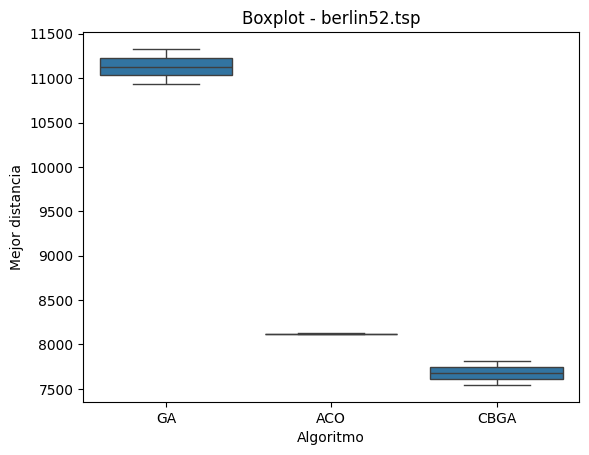

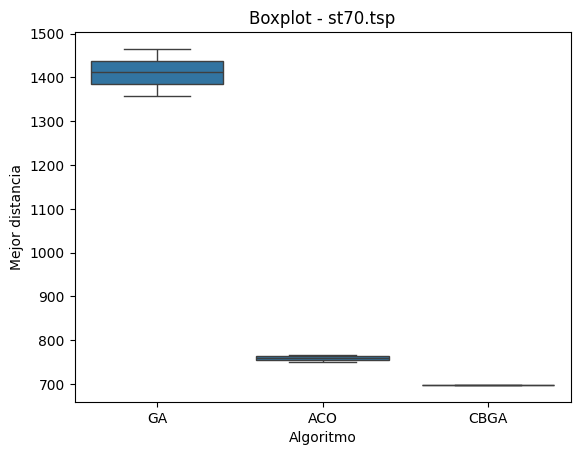

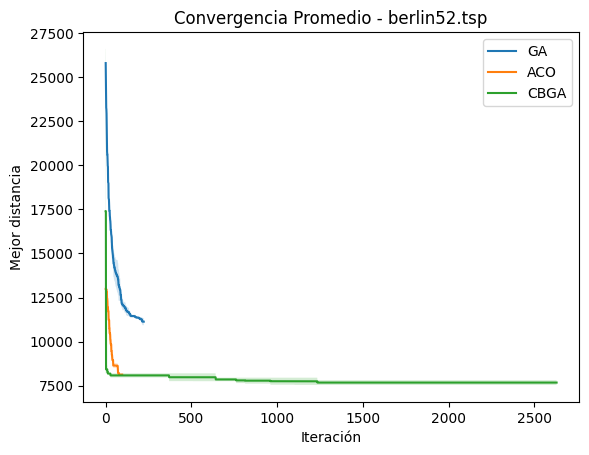

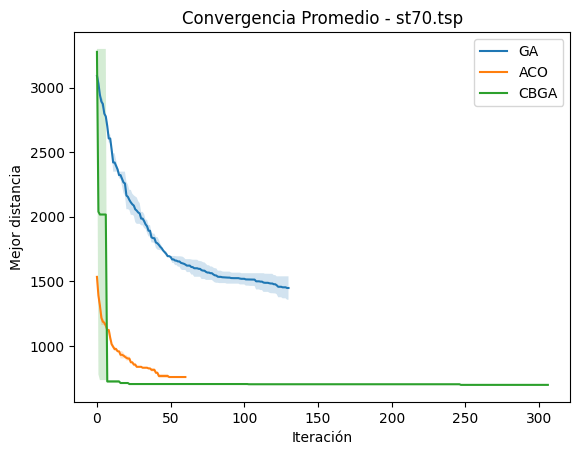

In [ ]:
# Construir tablas y gráficas
# - Crea una tabla final por instancia: GA vs ACO vs CBGA.
# - Genera boxplots por instancia.
# - Grafica convergencia promedio.

# Escribe tu implementación aquí.

# =====================================================
# TABLA RESUMEN FINAL
# =====================================================

tabla_resumen = df_fase3.groupby(["instancia","algoritmo"]).agg(
    promedio=("best","mean"),
    std=("best","std"),
    mejor=("best","min"),
    peor=("best","max"),
    gap_promedio=("gap_%","mean"),
    tiempo_promedio=("tiempo","mean")
).reset_index()

print("\n========= TABLA RESUMEN FINAL =========")
print(tabla_resumen)

for instancia in df_fase3["instancia"].unique():
    plt.figure()

    data = df_fase3[df_fase3["instancia"] == instancia]

    sns.boxplot(x="algoritmo", y="best", data=data)

    plt.title(f"Boxplot - {instancia}")
    plt.ylabel("Mejor distancia")
    plt.xlabel("Algoritmo")
    plt.show()



for instancia in df_fase3["instancia"].unique():

    plt.figure()

    for algoritmo in df_fase3["algoritmo"].unique():

        subset = df_fase3[
            (df_fase3["instancia"] == instancia) &
            (df_fase3["algoritmo"] == algoritmo)
        ]

        histories = subset["history"].tolist()

        min_len = min(len(h) for h in histories)
        histories = [h[:min_len] for h in histories]
        histories = np.array(histories)

        mean_curve = histories.mean(axis=0)
        std_curve = histories.std(axis=0)

        plt.plot(mean_curve, label=algoritmo)
        plt.fill_between(
            range(len(mean_curve)),
            mean_curve - std_curve,
            mean_curve + std_curve,
            alpha=0.2
        )

    plt.title(f"Convergencia Promedio - {instancia}")
    plt.xlabel("Iteración")
    plt.ylabel("Mejor distancia")
    plt.legend()
    plt.show()


---

# 8) Discusión: ¿qué algoritmo es mejor?

Guía de discusión (debes responder con evidencia):

1. ¿Quién obtiene el menor GAP promedio?
2. ¿Quién es más estable (menor desviación)?
3. ¿Quién llega más rápido a buenas soluciones?
4. ¿Qué ocurre cuando aumenta la dimensión?
5. ¿El tuning cambia el ganador?
6. ¿CBGA mejora GA? ¿En qué sentido (calidad/estabilidad/tiempo)?

✅ Tu conclusión debe indicar **para qué criterio** es mejor cada uno.

---

# 9) Entregables

## Entregable 1 (individual o grupo)
- PDF con: metodología, parámetros, resultados, tablas y gráficas, discusión y conclusión.
- Repositorio con:
  - Código (en módulos OOP)
  - Archivo(s) de resultados (CSV)
  - Notebook ejecutable

## Entregable 2 (presentación corta)
- 5–7 diapositivas: problema, métodos, diseño experimental, resultados, conclusión.

---

# Rúbrica sugerida (resumen)

- Implementación correcta (tours válidos, reproducibilidad): **25%**
- Metodología experimental justa (30 seeds, presupuesto): **20%**
- Métricas + visualizaciones + análisis: **25%**
- Tuning y justificación de parámetros: **20%**
- Discusión crítica y conclusiones: **10%**